<a href="https://colab.research.google.com/github/sauravdas093/Kaggle_Challenge/blob/main/2)Cross_Validation_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pixeltests School Data Science

*Unit 2, Sprint 2, Module 3*

---
<p style="padding: 10px; border: 2px solid red;">
    <b>Before you start:</b> Today is the day you should submit the dataset for your Unit 2 Build Week project. You can review the guidelines and make your submission in the Build Week course for your cohort on Canvas.</p>

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/pixeltests/datasets/main/' #You might not need this, use the data from Kaggle directly!
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Hyperparameter Tuning

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

- **Task 0:** Enter the [Kaggle](https://www.kaggle.com/t/6169ee7701164d24943c98eda2de9b5e) competition using exactly this link!
The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Establish the baseline accuracy score for your dataset.
- **Task 4:** Build `clf_dt`.
- **Task 5:** Build `clf_rf`.
- **Task 6:** Evaluate classifiers using k-fold cross-validation.
- **Task 7:** Tune hyperparameters for best performing classifier.
- **Task 8:** Print out best score and params for model.
- **Task 9:** Create `submission.csv` and upload to Kaggle.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

In [ ]:
def preprocess(df):
    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/demo/train_features.csv',na_values=[0, -2.000000e-08])
labels = pd.read_csv('/content/drive/MyDrive/demo/train_labels.csv',na_values=[0, -2.000000e-08])
df['status_group']=labels['status_group'].values
X_test = pd.read_csv('/content/drive/MyDrive/demo/test_features.csv',na_values=[0, -2.000000e-08])

In [ ]:
df = preprocess(df)
X_test = preprocess(X_test)

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [ ]:
X = df.drop('status_group',axis=1)
y = labels

In [ ]:
y = y['status_group']

# III. Establish Baseline

**Task 3:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
from sklearn.metrics import accuracy_score

majority_class = y.mode()[0]
y_pred= [majority_class] * len(y)
baseline_acc = accuracy_score(y, y_pred)
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5430765993265994


# IV. Build Models

**Task 4:** Build a `Pipeline` named `clf_dt`. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` Predictor.

**Note:** Do not train `clf_dt`. You'll do that in a subsequent task.

In [ ]:

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline


clf_dt = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=41)
)

**Task 5:** Build a `Pipeline` named `clf_rf`. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Do not train `clf_rf`. You'll do that in a subsequent task.

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


clf_rf = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs=-1, bootstrap = True, oob_score =True, random_state=25)
)


# V. Check Metrics

**Task 6:** Evaluate the performance of both of your classifiers using k-fold cross-validation.

In [ ]:
k = 3
cv_scores_dt = cross_val_score(clf_dt, X, y, cv=k,
                         scoring='accuracy')
cv_scores_rf = cross_val_score(clf_rf, X, y, cv=k,
                         scoring='accuracy')

In [ ]:
print('CV scores DecisionTreeClassifier')
print(cv_scores_dt)
print('Mean CV accuracy score:', cv_scores_dt.mean())
print('STD CV accuracy score:', cv_scores_dt.std())

CV scores DecisionTreeClassifier
[0.72872475 0.73162879 0.73314394]
Mean CV accuracy score: 0.7311658249158249
STD CV accuracy score: 0.0018335876187535428


In [ ]:
print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
[0.79065657 0.80113636 0.7957702 ]
Mean CV accuracy score: 0.795854377104377
STD CV accuracy score: 0.004278773617750897


# VI. Tune Model

**Task 7:** Choose the best performing of your two models and tune its hyperparameters using a `RandomizedSearchCV` named `model`. Make sure that you include cross-validation and that `n_iter` is set to at least `25`.

**Note:** If you're not sure which hyperparameters to tune, check the notes from today's guided project and the `sklearn` documentation.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__bootstrap':[True,False],
}

search = RandomizedSearchCV(
    clf_rf,
    param_distributions=param_distributions,
    n_iter=5,
    cv=5,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)
search.fit(X, y);

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True"

In [ ]:
# model = ...

**Task 8:** Print out the best score and best params for `model`.

In [ ]:
best_score = search.best_score_
best_params = search.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.8004419191919192
Best params for `model`: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__bootstrap': True}


# Communicate Results

**Task 9:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site.

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting.

In [ ]:
y_pred = search.predict(X_test)

In [ ]:
sample = pd.read_csv('/content/drive/MyDrive/demo/tanzania sample solution.csv')

submission = sample[['S.No.']].copy()
submission['status_group'] = y_pred

submission['status_group1'] = submission[['status_group']]
submission = submission.set_index("status_group1")
submission.loc[['functional'], ['status_group']] = 0
submission.loc[['functional needs repair'], ['status_group']] = 1
submission.loc[['non functional'], ['status_group']] = 2
submission = submission.reset_index()
submission = submission.drop('status_group1',axis=1)
submission

,S.No.,status_group
0,1,0
1,2,0
2,3,0
3,4,2
4,5,0
...,...,...
11875,11876,2
11876,11877,2
11877,11878,2
11878,11879,0


In [ ]:
submission.to_csv('Tanzania_water_pump-03.csv', index=False)

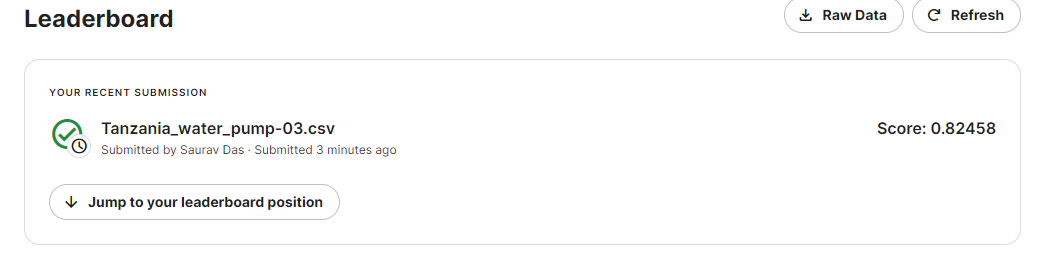

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/demo/Predict-faulty-Tanzania-Water-Pumps-Kaggle_cross_validation.png')